# Assessing Quality of Nighttime Lights Data

### Overview <a name="overview"></a>

The quality of nighttime lights data can be impacted by a number of factors, particularly cloud cover. To facilitate analysis using high quality data, Black Marble (1) marks the quality of each pixel and (2) in some cases of poor quality pixels, Black Marble will use data from a previous date to fill the value---using a temporally-gap filled NTL value. Below we illustrate how to examine the quality of nighttime lights data.

### Setup <a name="setup"></a>

We first load packages and obtain a polygon for a region of interest; for this example, we use Switzerland. 

In [1]:
import datetime
import glob
import os
import time

import colorcet as cc
import contextily as cx
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from gadm import GADMDownloader
from rasterstats import zonal_stats

from blackmarble.extract import bm_extract
from blackmarble.raster import bm_raster, transform

plt.rcParams["figure.figsize"] = (15, 5)
%load_ext autoreload
%autoreload 2

In [2]:
bearer = os.getenv("BLACKMARBLE_TOKEN")

In [3]:
gdf = GADMDownloader(version="4.0").get_shape_data_by_country_name(
    country_name="Switzerland", ad_level=0
)

### Daily Data <a name="daily"></a>

Below shows an example examining quality for daily data (`VNP46A2`).

#### Nighttime Lights <a name="daily-ntl"></a>

We download data for January 1st, 2023. When the `variable` parameter is not specified, `bm_raster` creates a raster using the `Gap_Filled_DNB_BRDF-Corrected_NTL` variable for daily data.

In [4]:
ntl_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="Gap_Filled_DNB_BRDF-Corrected_NTL",
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

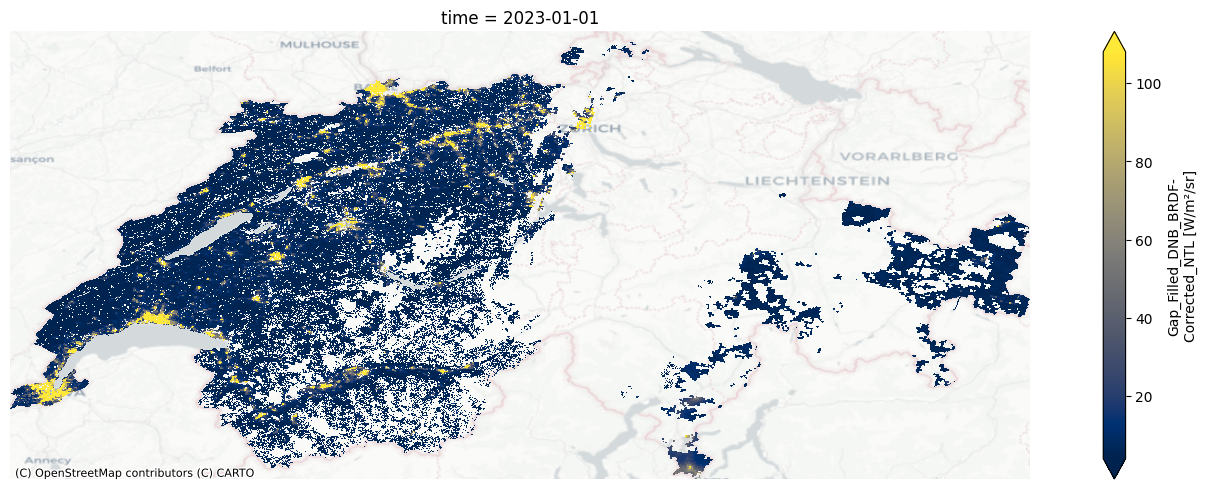

In [5]:
fig, ax = plt.subplots()

ntl_r["Gap_Filled_DNB_BRDF-Corrected_NTL"].sel(time="2023-01-01").plot(
    robust=True, cmap="cividis"
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

We notice that a number of observations are missing, that are poor quality and are not gap-filled. To understand the extent of missing date, we can use the following code to determine (1) the total number of pixels that cover Switzerland, (2) the total number of non-`NA` nighttime light pixels, and (3) the proportion of non-`NA` pixels.

In [6]:
ntl_np = ntl_r["Gap_Filled_DNB_BRDF-Corrected_NTL"].sel(time="2023-01-01")

n_pixel = zonal_stats(
    gdf,
    ntl_np.values,
    affine=transform(ntl_np),
    nodata=np.nan,
    masked=False,
    stats=["count", "nan"],
)

In [7]:
## Number of pixels
n_pixel[0]["count"] + n_pixel[0]["nan"]

280801.0

In [8]:
## Number of non nan pixels
n_pixel[0]["count"]

120617

In [9]:
## Proportion of non nan pixels
n_pixel[0]["count"] / (n_pixel[0]["count"] + n_pixel[0]["nan"])

0.4295461910748181

By default, `bm_extract` computes the mean; we can easily also compute the number of pixels and number of nan pixels.

In [10]:
date_range = pd.date_range(
    "2023-01-01",
    "2023-01-10",
    freq="D",
)
ntl_df = bm_extract(
    roi=gdf,
    product_id="VNP46A2",
    date_range=date_range,
    bearer=bearer,
    variable="Gap_Filled_DNB_BRDF-Corrected_NTL",
    aggfunc=["mean", "count", "nan"],
)

QUEUEING TASKS | Downloading...:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/6.18M [00:00<?, ?B/s]

  0%|          | 0.00/4.34M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

  0%|          | 0.00/6.79M [00:00<?, ?B/s]

  0%|          | 0.00/4.39M [00:00<?, ?B/s]

  0%|          | 0.00/6.78M [00:00<?, ?B/s]

  0%|          | 0.00/5.44M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/6.75M [00:00<?, ?B/s]

  0%|          | 0.00/4.24M [00:00<?, ?B/s]

  0%|          | 0.00/5.65M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

  0%|          | 0.00/5.96M [00:00<?, ?B/s]

  0%|          | 0.00/5.91M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.01M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/6.32M [00:00<?, ?B/s]

  0%|          | 0.00/5.00M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/20 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
ntl_df["prop_non_na_pixels"] = ntl_df["ntl_count"] / (
    ntl_df["ntl_count"] + ntl_df["ntl_nan"]
)

In [12]:
ntl_df

COUNTRY ID_0                                           geometry  \
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   

    ntl_mean  ntl_count   ntl_nan       date  prop_non_na_pixels  
0  15.122785     120617  160184.0 2023-01-01            0.429546  
0  13.535337     133232  147569.0 2023-01-02            0.474471  
0   6.982172       9760  271041.0 2023-01-03            0.034758  
0  11.336155     125576  155225.0 2023-01-04            0.447206  
0   3.693041       7242  273559.0 2023-01-05            0.025791  
0  12.002285     124726  156075.0 2023-01-06            0.444179  
0  10.214094      88508  192293.0 2023-01-07            0.315198  
0  11.595038     120073  160728.0 2023-01-08            0.427609  
0  16.461794      25559  255242.0 2023-01-09            0.091022  
0  16.802839      40926  239875.0 2023-01-10            0.145747

The below figure shows trends in average nighttime lights (left) and the proportion of the country with a value for nighttime lights (right). For some days, low number of pixels corresponds to low nighttime lights (eg, January 3 and 5th); however, for other days, low number of pixels corresponds to higher nighttime lights (eg, January 9 and 10). On January 3 and 5, missing pixels could have been over typically high-lit areas (eg, cities)---while on January 9 and 10, missing pixels could have been over typically lower-lit areas. 


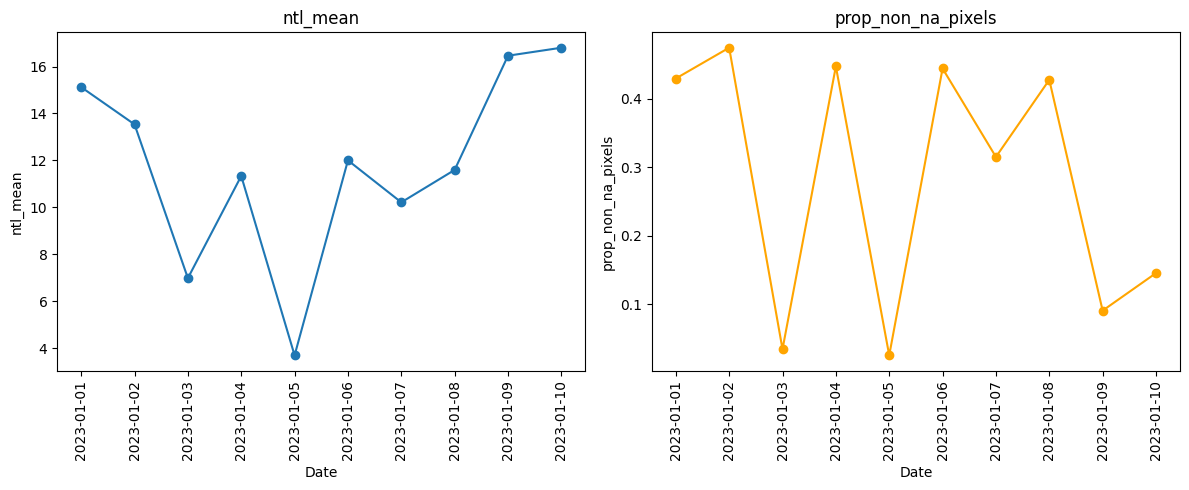

In [13]:
fig, axs = plt.subplots(
    1, 2, figsize=(12, 5)
)  # 1 row, 2 columns for side-by-side plots

# Left plot (date vs ntl_mean)
axs[0].plot(ntl_df["date"], ntl_df["ntl_mean"], marker="o", linestyle="-")
axs[0].set_title("ntl_mean")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("ntl_mean")
axs[0].tick_params(axis="x", rotation=90)

# Right plot (date vs prop_na)
axs[1].plot(
    ntl_df["date"],
    ntl_df["prop_non_na_pixels"],
    marker="o",
    linestyle="-",
    color="orange",
)
axs[1].set_title("prop_non_na_pixels")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("prop_non_na_pixels")
axs[1].tick_params(axis="x", rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

#### Quality <a name="daily-quality"></a>

For daily data, the quality values are:

* 0: High-quality, Persistent nighttime lights

* 1: High-quality, Ephemeral nighttime Lights

* 2: Poor-quality, Outlier, potential cloud contamination, or other issues

* 255: No retrieval, Fill value (masked out on ingestion)

We can map quality by using the `Mandatory_Quality_Flag` variable.

In [14]:
quality_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="Mandatory_Quality_Flag",
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

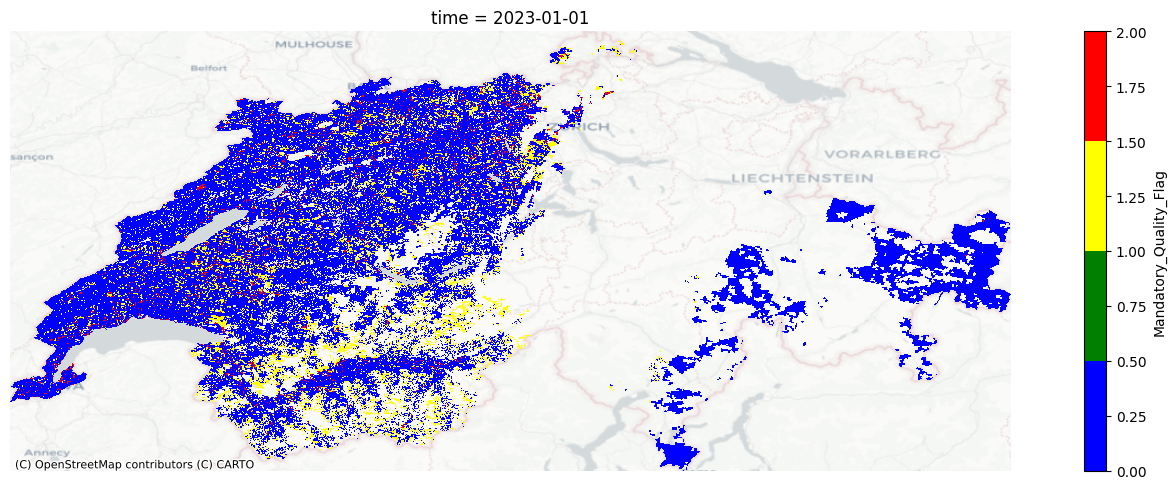

In [15]:
fig, ax = plt.subplots()

# Create a discrete colormap
cmap = mcolors.ListedColormap(["blue", "green", "yellow", "red"])
# Plot
quality_r["Mandatory_Quality_Flag"].sel(time="2023-01-01").plot(ax=ax, cmap=cmap)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout();

#### Nighttime lights for good quality observations <a name="daily-goodq"></a>

The `quality_flag_rm` parameter determines which pixels are set to `NA` based on the quality indicator. By default, only pixels with a value of `255` are filtered out. However, if we only want data for good quality pixels, we can adjust the `quality_flag_rm` parameter.

In [16]:
ntl_good_qual_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="Gap_Filled_DNB_BRDF-Corrected_NTL",
    quality_flag_rm=[2, 255],
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

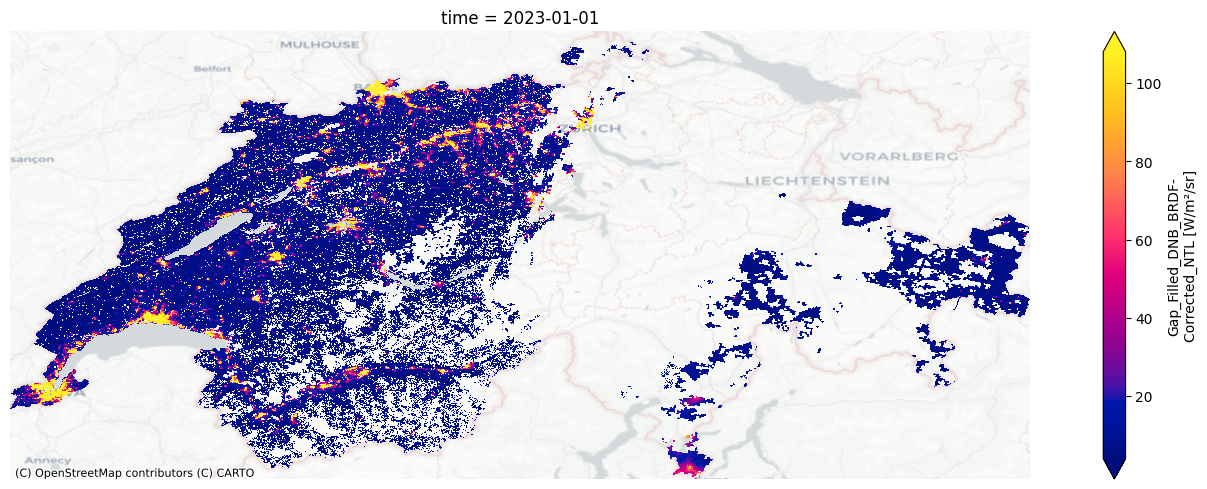

In [17]:
fig, ax = plt.subplots()

# Plot
ntl_good_qual_r["Gap_Filled_DNB_BRDF-Corrected_NTL"].sel(time="2023-01-01").plot(
    ax=ax, cmap=cc.cm.bmy, robust=True
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

#### Nighttime lights for good quality observations, without gap filling <a name="daily-nogap"></a>

By default, the `bm_raster` function uses the `Gap_Filled_DNB_BRDF-Corrected_NTL` variable for daily data. Gap filling indicates that some poor quality pixels use data from a previous date; the `Latest_High_Quality_Retrieval` indicates the date the nighttime lights value came from.

In [18]:
ntl_tmp_gap_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="Latest_High_Quality_Retrieval",
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

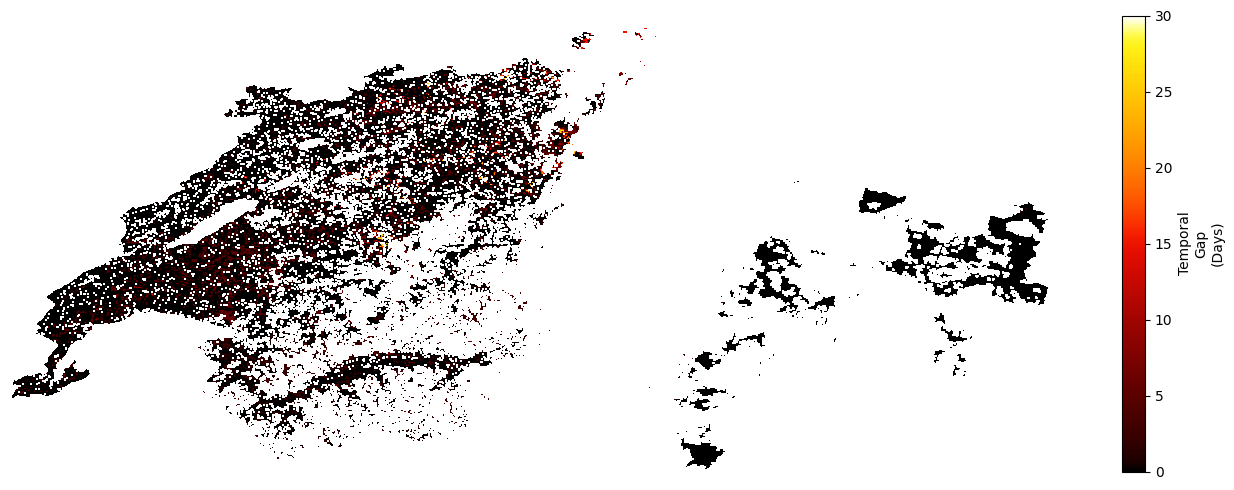

In [19]:
r_np = ntl_tmp_gap_r["Latest_High_Quality_Retrieval"].sel(time="2023-01-01")
r_np = np.where(r_np == 255, np.nan, r_np)

plt.imshow(r_np, cmap=cc.cm.fire)
plt.axis("off")
plt.colorbar(
    label="Temporal\nGap\n(Days)"
)  # Add a colorbar with ticks for discrete values
plt.tight_layout()

Instead of using `Gap_Filled_DNB_BRDF-Corrected_NTL`, we could ignore gap filled observations---using the `DNB_BRDF-Corrected_NTL` variable. Here, we also remove poor quality pixels.

In [20]:
ntl_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="DNB_BRDF-Corrected_NTL",
    quality_flag_rm=[2, 255],
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

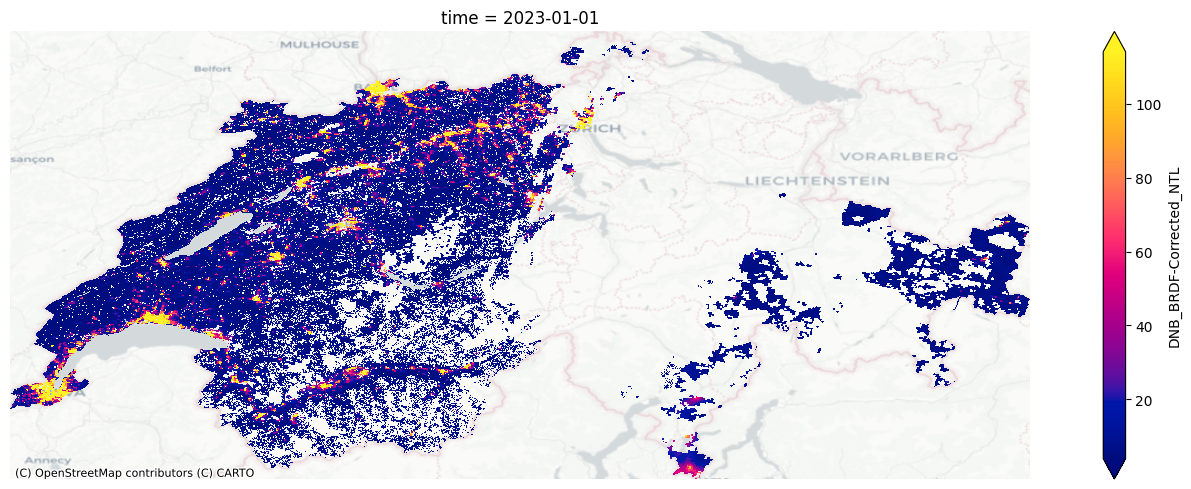

In [21]:
fig, ax = plt.subplots()

# Plot
ntl_r["DNB_BRDF-Corrected_NTL"].sel(time="2023-01-01").plot(
    ax=ax, cmap=cc.cm.bmy, robust=True
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

### Monthly/Annual Data <a name="ma"></a>

Below shows an example examining quality for monthly data (`VNP46A3`). The same approach can be used for annual data (`VNP46A4`); the variables are the same for both monthly and annual data.

#### Nighttime Lights <a name="ma-ntl"></a>

We download data for January 2023. When the `variable` parameter is not specified, `bm_raster` creates a raster using the `NearNadir_Composite_Snow_Free` variable for monthly and annual data---which is nighttime lights, removing effects from snow cover. 

In [22]:
ntl_r = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range="2023-01-01",
    bearer=bearer,
    variable="NearNadir_Composite_Snow_Free",
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/25.2M [00:00<?, ?B/s]

  0%|          | 0.00/28.6M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

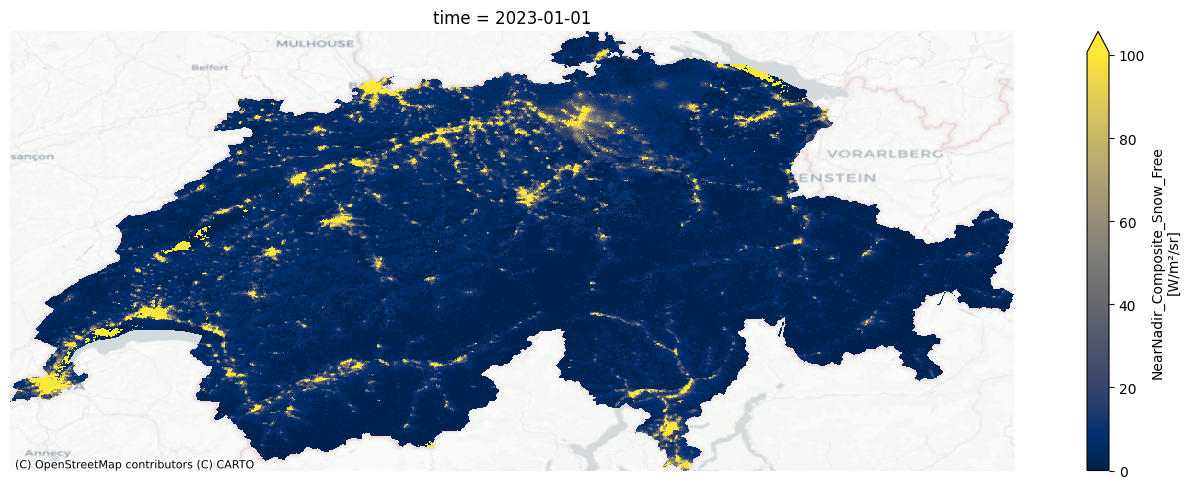

In [23]:
fig, ax = plt.subplots()

ntl_r["NearNadir_Composite_Snow_Free"].sel(time="2023-01-01").plot(
    robust=True, cmap="cividis"
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

#### Number of Observations <a name="ma-numobs"></a>

Black Marble removes poor quality observations, such as pixels covered by clouds. To determine the number of observations used to generate nighttime light values for each pixel, we add `_Num` to the variable name.

In [24]:
cf_r = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range="2023-01-01",
    bearer=bearer,
    variable="NearNadir_Composite_Snow_Free_Num",
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/28.6M [00:00<?, ?B/s]

  0%|          | 0.00/25.2M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

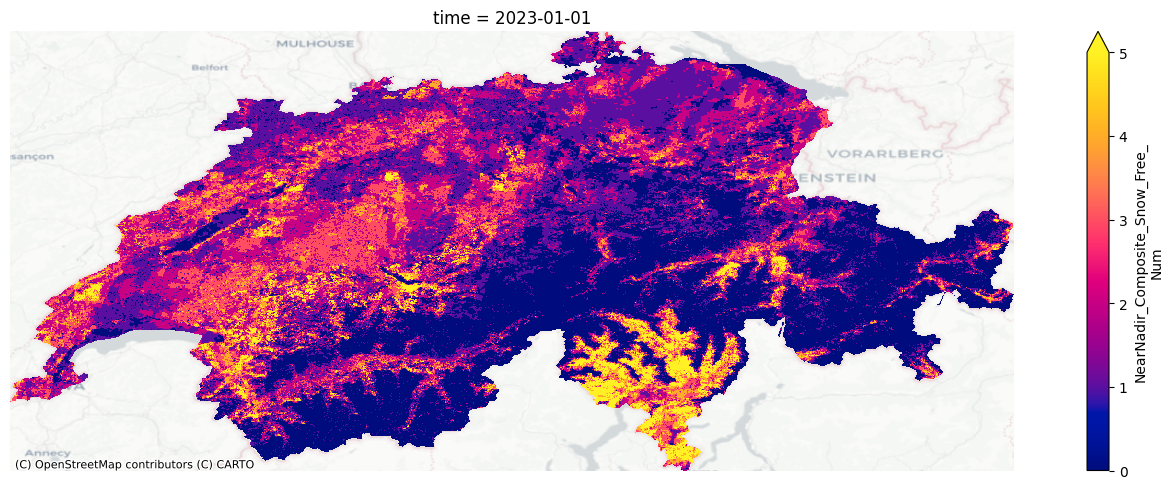

In [25]:
fig, ax = plt.subplots()

cf_r["NearNadir_Composite_Snow_Free_Num"].sel(time="2023-01-01").plot(
    robust=True, cmap=cc.cm.bmy
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

#### Quality <a name="ma-quality"></a>

For monthly and annual data, the quality values are:

* 0: Good-quality, The number of observations used for the composite is larger than 3

* 1: Poor-quality, The number of observations used for the composite is less than or equal to 3

* 2: Gap filled NTL based on historical data

* 255: Fill value

We can map quality by adding `_Quality` to the variable name.


In [26]:
quality_r = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range="2023-01-01",
    bearer=bearer,
    variable="NearNadir_Composite_Snow_Free_Quality",
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/28.6M [00:00<?, ?B/s]

  0%|          | 0.00/25.2M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

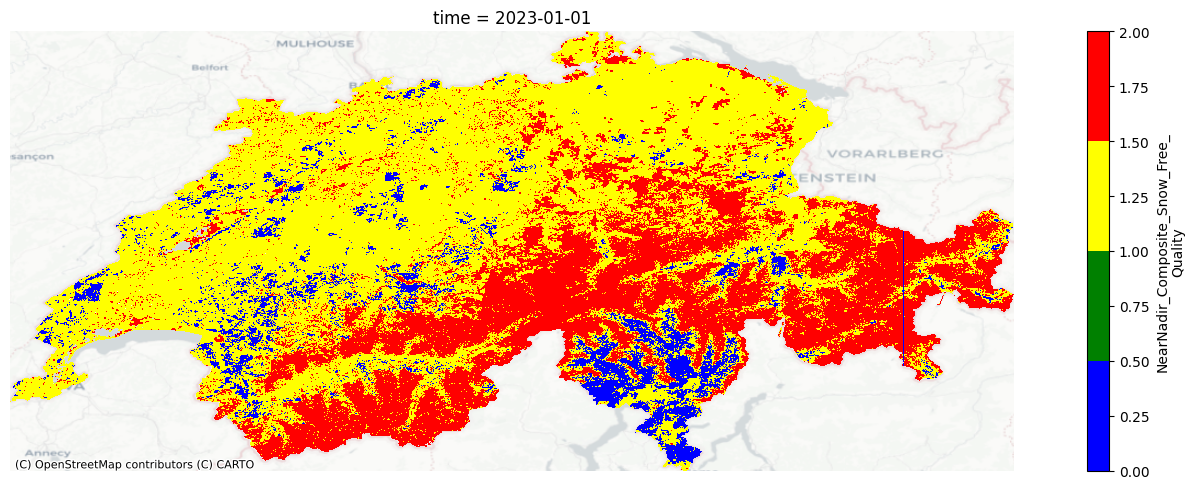

In [27]:
fig, ax = plt.subplots()

# Create a discrete colormap
cmap = mcolors.ListedColormap(["blue", "green", "yellow", "red"])
# Plot
quality_r["NearNadir_Composite_Snow_Free_Quality"].sel(time="2023-01-01").plot(
    ax=ax, cmap=cmap
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout();

#### Nighttime lights for good quality observations <a name="ma-ntl_gq"></a>

The `quality_flag_rm` parameter determines which pixels are set to `NA` based on the quality indicator. By default, only pixels with a value of `255` are filtered out. However, if we also want to remove poor quality pixels, we can adjust the `quality_flag_rm` parameter.

In [28]:
ntl_good_qual_r = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range="2023-01-01",
    bearer=bearer,
    variable="NearNadir_Composite_Snow_Free",
    quality_flag_rm=[2, 255],
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/25.2M [00:00<?, ?B/s]

  0%|          | 0.00/28.6M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

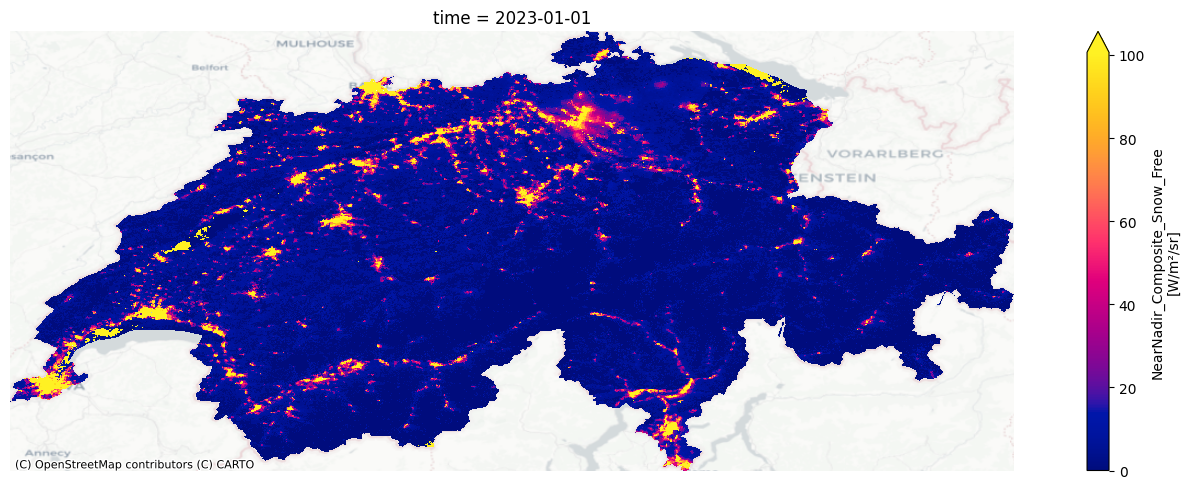

In [29]:
fig, ax = plt.subplots()

# Plot
ntl_r["NearNadir_Composite_Snow_Free"].sel(time="2023-01-01").plot(
    ax=ax, cmap=cc.cm.bmy, robust=True
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()